# Skip-gram word2vec


In this notebook, I'll lead you through using TensorFlow to implement the word2vec algorithm using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

When you're dealing with words in text, you end up with tens of thousands of classes to predict, one for each word. Trying to one-hot encode these words is massively inefficient, you'll have one element set to 1 and the other 50,000 set to 0. The matrix multiplication going into the first hidden layer will have almost all of the resulting values be zero. This a huge waste of computation.

To solve this problem and greatly increase the efficiency of our networks, we use what are called embeddings. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an embedding lookup and the number of hidden units is the embedding dimension.

The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix as well.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called Word2Vec uses the embedding layer to find vector representations of words that contain semantic meaning.

## Word2Vec

The word2vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words. Words that show up in similar contexts, such as "black", "white", and "red" will have vectors near each other. There are two architectures for implementing word2vec, CBOW (Continuous Bag-Of-Words) and Skip-gram.

In this implementation, we'll be using the skip-gram architecture because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

In [1]:
import time
import numpy as np
import tensorflow as tf
import re
from collections import Counter

C:\Users\snettani\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Create Utilities functions

In [2]:
def preprocess(text):
    #Repalce punctuations as tokens so that we can use them in our model
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    text = text.replace('/', ' <SLASH> ')
    words = text.split()
    
    #Remove all words with 5 or fewer occurances
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]
    return trimmed_words

def preprocess_with_space(text):
    #Repalce punctuations as tokens so that we can use them in our model
    text = text.lower()
    text = text.replace('.', ' ')
    text = text.replace(',', ' ')
    text = text.replace('"', ' ')
    text = text.replace(';', ' ')
    text = text.replace('!', ' ')
    text = text.replace('?', ' ')
    text = text.replace('(', ' ')
    text = text.replace(')', ' ')
    text = text.replace('--', ' ')
    text = text.replace('\n', ' ')
    text = text.replace(':', ' ')
    text = text.replace('/', ' ')
    words = text.split()
    
    #Remove all words with 5 or fewer occurances
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]
    return trimmed_words

def get_batches(text_ids, batch_size, seq_len):
    n_batches = int(len(text_ids) / (batch_size*seq_len))
    
    #drop the last few words to make the batches full
    xdata = np.array(text_ids[: n_batches * batch_size * seq_len])
    ydata = np.array(text_ids[1:n_batches * batch_size * seq_len + 1])
    
    x_batches = np.split(text_ids.reshape(batch_size, -1), n_batches, 1)
    y_batches = np.split(text_ids.reshape(batch_size, -1), n_batches, 1)
    return list(zip(x_batches, y_batches))

def create_lookup_tables(words):
    word_counts = Counter(words)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}
    return vocab_to_int, int_to_vocab

## Load data

In [31]:
with open('attention.txt') as f:
    text = f.read()

In [32]:
text

"Oh-oh, ooh\nYou've been runnin' round, runnin' round, runnin' round throwin' that dirt all on my name\n'Cause you knew that I, knew that I, knew sandesh prabhu that I'd call you up\nYou've been going round, going round, going round every party in L.A.\n'Cause you knew that I, knew that I, knew that I'd be at one, oh\nI know that dress is karma, perfume sandesh prabhu regret\nYou got me thinking sandesh prabhu 'bout when you were mine, oh\nAnd now I'm all up on ya, what you expect?\nBut you're not coming home with me tonight\nYou just want attention, you don't want my heart\nMaybe you just hate the thought of me with someone new\nYeah sandesh prabhu, you just want attention, I knew from the start\nYou're just making sure I'm never gettin' over you\nyou've been sandesh prabhu runnin' round, runnin' round, runnin' round throwing that dirt all on my name\n'Cause you knew that I, knew that I, knew that I'd call you up\nBaby, now sandesh prabhu that we're, now that we're, now that we're rig

## Preprocessing

The preprocess function coverts any punctuation into tokens, so a period is changed to <PERIOD>. In this data set, there aren't any periods, but it will help in other NLP problems. I'm also removing all words that show up five or fewer times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. If you want to write your own functions for this stuff, go for it.

In [33]:
words = preprocess_with_space(text)
print(words[:30])

["runnin'", 'round', "runnin'", 'round', "runnin'", 'round', 'that', 'all', 'on', 'you', 'knew', 'that', 'i', 'knew', 'that', 'i', 'knew', 'sandesh', 'prabhu', 'that', 'you', 'up', 'round', 'round', 'round', 'you', 'knew', 'that', 'i', 'knew']


In [34]:
print('Total words: {}'.format(len(words)))
print('unique words: {}'.format(len(set(words))))

Total words: 348
unique words: 27


And here I'm creating dictionaries to covert words to integers and backwards, integers to words. The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1 and so on. The words are converted to integers and stored in the list int_words.

In [35]:
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$
where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

In [36]:
import random

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count / total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold / freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to grab all the words in a window around that word, with size $C$.

In [37]:
def get_target(words, index, window_size=5):
    R = np.random.randint(1, window_size+1)
    start = index - R if (index - R) > 0 else 0
    stop = index + R
    target_words = set(words[start:index] + words[index+1:stop+1])
    return list(target_words)


Here's a function that returns batches for our network. The idea is that it grabs batch_size words from a words list. Then for each of those words, it gets the target words in the window. I haven't found a way to pass in a random number of target words and get it to work with the architecture, so I make one row per input-target pair. This is a generator function by the way, helps save memory.

In [38]:
def get_batches(words, batch_size, window_size=5):
    n_batches = len(words) // batch_size
    words = words[:n_batches * batch_size]
    for index in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[index:index + batch_size]
        for i in range(len(batch)):
            batch_x = batch[i]
            batch_y = get_target(batch, i, window_size)
            y.extend(batch_y)
            x.extend([batch_x] * len(batch_y))
        yield x, y

## Building the graph

The input words are passed in as one-hot encoded vectors. This will go into a hidden layer of linear units, then into a softmax layer. We'll use the softmax layer to make a prediction like normal.

The idea here is to train the hidden layer weight matrix to find efficient representations for our words. We can discard the softmax layer becuase we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in other networks we build from the dataset.

In [39]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

## Embedding

The embedding matrix has a size of the number of words by the number of units in the hidden layer. So, if you have 10,000 words and 300 hidden units, the matrix will have size $10,000 \times 300$. Remember that we're using tokenized data for our inputs, usually as integers, where the number of tokens is the number of words in our vocabulary.

In [40]:
n_vocab = len(int_to_vocab)
n_embedding = 200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

## Negative sampling


For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called "negative sampling". Tensorflow has a convenient function to do this, tf.nn.sampled_softmax_loss.

In [41]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

## Validation


This code is from Thushan Ganegedara's implementation. Here we're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [42]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [43]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

A subdirectory or file checkpoints already exists.


In [51]:
epochs = 100
batch_size = 100
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Restore the trained network if you need to:

In [45]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints\text8.ckpt


## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture.

In [46]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [47]:
viz_words = 100
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])
print(embed_tsne.shape)

(27, 2)


IndexError: index 27 is out of bounds for axis 0 with size 27

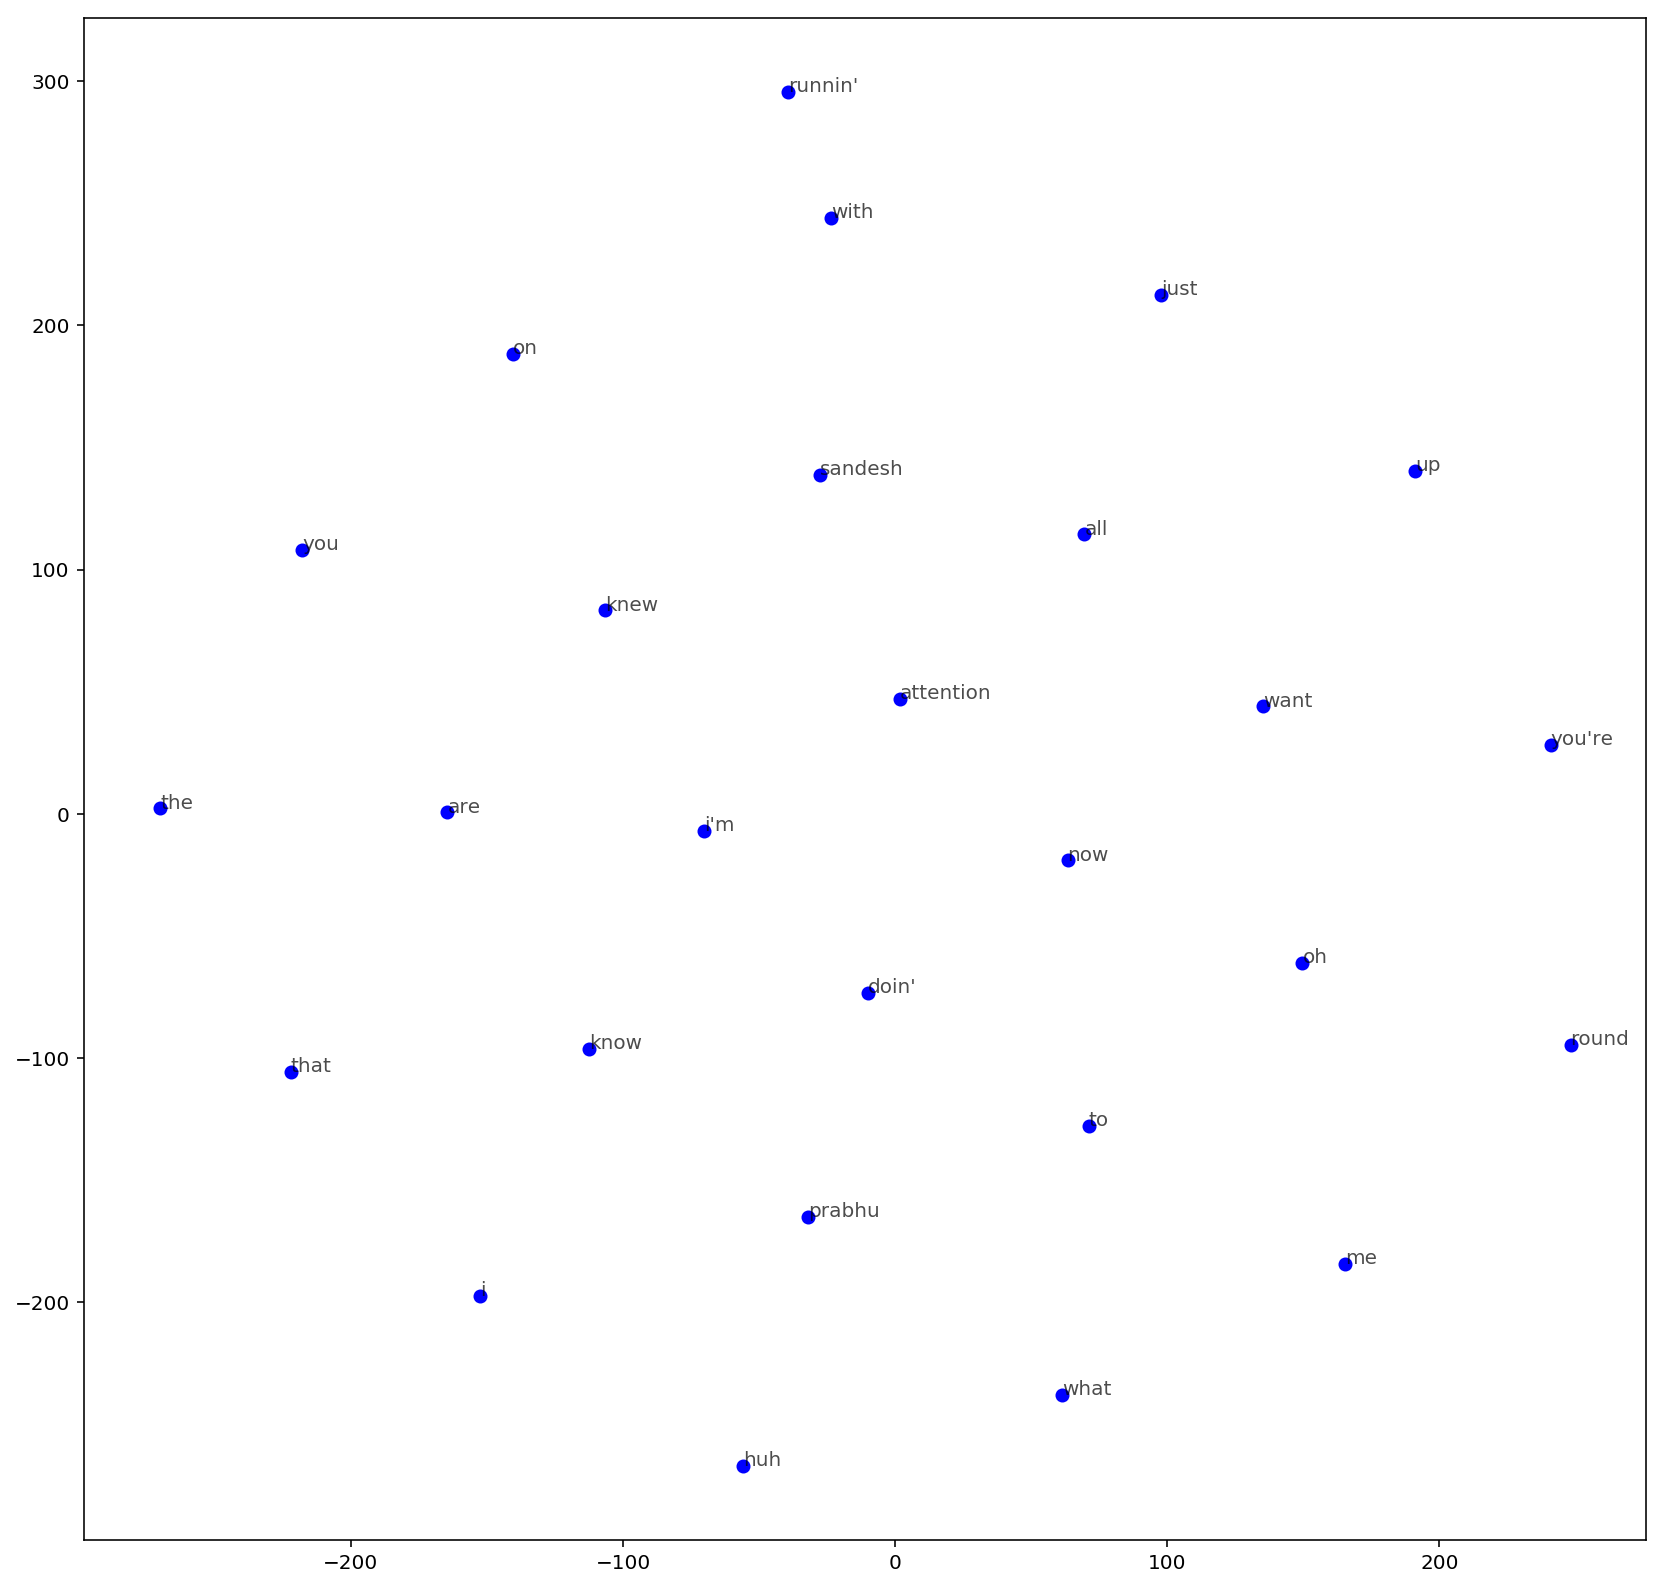

In [48]:
fig, ax = plt.subplots(figsize=(14,14))
for index in range(viz_words):
    plt.scatter(*embed_tsne[index, :], color='blue')
    plt.annotate(int_to_vocab[index], (embed_tsne[index, 0], embed_tsne[index, 1]), alpha=0.7)